In [ ]:
! pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import logging
import time
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode

import tensorflow as tf

In [ ]:
data = pd.read_csv('/content/news_summary.csv', encoding='latin')


In [ ]:
data.columns

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')

In [ ]:
data=data[['ctext','text']]
data.columns = ['text', 'summary']

In [ ]:
data.head()

,text,summary
0,The Daman and Diu administration on Wednesday ...,The Administration of Union Territory Daman an...
1,"From her special numbers to TV?appearances, Bo...",Malaika Arora slammed an Instagram user who tr...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...


In [ ]:
def clean_text(texts):
    texts=str(texts)
    texts = texts.lower() #convert uppercase to lowercase
    texts = unidecode(texts, errors='ignore') #convert accented letters into unaccented letters. Ignore unknown characters.
    texts = ''.join((char if char in (string.punctuation + string.ascii_lowercase) else ' ' for char in texts)) #keep the selected letters and punctuation.

    return texts

In [ ]:
data['text']=data['text'].apply(lambda x:clean_text(x))


In [ ]:
data['summary']=data['summary'].apply(lambda x:clean_text(x))


In [ ]:
data['summary'].head()


0    the administration of union territory daman an...
1    malaika arora slammed an instagram user who tr...
2    the indira gandhi institute of medical science...
3    lashkar-e-taiba's kashmir commander abu dujana...
4    hotels in maharashtra will train their staff t...
Name: summary, dtype: object

In [ ]:
word2count = {}

for line in data['text']:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
for line in data['summary']:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

In [ ]:
print(word2count)

{'the': 108193, 'daman': 10, 'and': 39561, 'diu': 8, 'administration': 240, 'on': 17673, 'wednesday': 360, 'withdrew': 18, 'a': 37561, 'circular': 42, 'that': 16756, 'asked': 1385, 'women': 852, 'staff': 327, 'to': 47433, 'tie': 48, 'rakhis': 6, 'male': 145, 'colleagues': 60, 'after': 5371, 'order': 594, 'triggered': 54, 'backlash': 20, 'from': 8919, 'employees': 226, 'was': 14666, 'ripped': 12, 'apart': 123, 'social': 610, 'media.the': 11, 'union': 507, 'territory?s': 2, 'forced': 237, 'retreat': 20, 'within': 539, 'hours': 351, 'of': 44281, 'issuing': 62, 'made': 1717, 'it': 8650, 'compulsory': 52, 'for': 17343, 'its': 3154, 'celebrate': 112, 'rakshabandhan': 10, 'at': 9306, 'workplace.?it': 2, 'has': 11465, 'been': 5451, 'decided': 545, 'festival': 91, 'august': 268, '.': 6481, 'in': 38832, 'this': 5224, 'connection,': 7, 'all': 3081, 'offices/': 2, 'departments': 73, 'shall': 100, 'remain': 173, 'open': 459, 'collectively': 12, 'suitable': 25, 'time': 1528, 'wherein': 81, 'lady': 6

In [ ]:
thresh = 5

vocab = {}
word_num = 0
for word, count in word2count.items():
    if count >= thresh:
        vocab[word] = word_num
        word_num += 1


data['summary'] = '<SOS> ' + data['summary'] + ' <EOS>'

del word,count

tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocab)
for token in tokens:
    vocab[token] = x
    x += 1

vocab['cameron'] = vocab['<PAD>']
vocab['<PAD>'] = 0

### inv answers dict ###
inv_vocab = {w:v for v, w in vocab.items()}
del token

In [ ]:
encoder_inp = []
for line in data['text']:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])

    encoder_inp.append(lst)

decoder_inp = []
for line in data['summary']:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])
    decoder_inp.append(lst)

In [ ]:
max_len_txt=150
max_len_summ=50

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_inp = pad_sequences(encoder_inp, max_len_txt, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, max_len_summ, padding='post', truncating='post')

In [ ]:
def prepare_batch(pt, en):
    en_inputs = en[:, :-1]  # Drop the [END] tokens
    en_labels = en[:, 1:]  # Drop the [START] tokens
    print(en_inputs.shape,en_labels.shape)
    return (pt, en_inputs), en_labels

In [ ]:
X_train,y_train=prepare_batch(encoder_inp,decoder_inp)

(4514, 49) (4514, 49)


In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x


In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x



class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x



In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)
    return x

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    context, x  = inputs

    context = self.encoder(context)


    x = self.decoder(x, context)

    # Final linear layer output.
    logits = self.final_layer(x)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1


In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(vocab),
    target_vocab_size=len(vocab),
    dropout_rate=dropout_rate)


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Set up loss and matrix

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
history = transformer.fit(X_train,y_train,
                epochs=20,
                batch_size=64,
                         validation_split=0.2)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Define Hyperparameters
BATCH_SIZE = 128
BUFFER_SIZE = len(encoder_inp)
steps_per_epoch = len(encoder_inp) // BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(vocab)
vocab_tar_size = len(vocab)

# Optimizer with adjusted learning rate
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.0005)

transformer2 = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(vocab),
    target_vocab_size=len(vocab),
    dropout_rate=dropout_rate)


# Compile and Train Model
transformer2.compile(
    loss=masked_loss,
    optimizer=optimizer2,
    metrics=[masked_accuracy])

history2 = transformer2.fit(X_train, y_train,
                          epochs=30,  # Increased number of epochs
                          batch_size=BATCH_SIZE,  # Adjusted batch size
                          validation_split=0.2)


Epoch 1/30
29/29 [==============================] - 53s 695ms/step - loss: 9.1667 - masked_accuracy: 0.0611 - val_loss: 8.3301 - val_masked_accuracy: 0.0594
Epoch 2/30
29/29 [==============================] - 18s 629ms/step - loss: 7.8139 - masked_accuracy: 0.0627 - val_loss: 7.4879 - val_masked_accuracy: 0.0594
Epoch 3/30
29/29 [==============================] - 20s 679ms/step - loss: 7.2874 - masked_accuracy: 0.0630 - val_loss: 7.3074 - val_masked_accuracy: 0.0594
Epoch 4/30
29/29 [==============================] - 20s 689ms/step - loss: 7.2103 - masked_accuracy: 0.0630 - val_loss: 7.3106 - val_masked_accuracy: 0.0594
Epoch 5/30
29/29 [==============================] - 20s 707ms/step - loss: 7.2034 - masked_accuracy: 0.0628 - val_loss: 7.3194 - val_masked_accuracy: 0.0594
Epoch 6/30
29/29 [==============================] - 20s 701ms/step - loss: 7.1998 - masked_accuracy: 0.0633 - val_loss: 7.3259 - val_masked_accuracy: 0.0594
Epoch 7/30
29/29 [==============================] - 21s 71

In [ ]:
max_len=max_len_summ
def pad_seq(seq, max_length=max_len, pad_token_id=0):
        if len(seq) > max_length:
            pad = seq[:max_length]
        else:
            pad = seq + [pad_token_id]*(max_length-len(seq))

        return pad

In [ ]:
import tensorflow as tf
def predict(text_dialogue, model=transformer2, return_sent=False, print_gen=True):

    clean_txt = clean_text(text_dialogue)
    encoder_inp = []
    for word in clean_txt.split():
        if word not in vocab:
            encoder_inp.append(vocab['<OUT>'])
        else:
            encoder_inp.append(vocab[word])

    encoder_inp = pad_seq(encoder_inp, max_len)
    decoder_inp = np.zeros(max_len, dtype=np.int32)
    decoder_inp[0]= vocab['<SOS>']
    predict = -1
    output = []
    i = 0
    sentiment =''
    while predict!= vocab['<EOS>'] and i<max_len-1:
        softmax = tf.keras.layers.Softmax()
        test_predict = softmax(model.predict([np.expand_dims(encoder_inp, axis=0),
                                              np.expand_dims(decoder_inp, axis=0)], verbose=False))
        predict = np.argmax(test_predict[0][i])
        output += [predict]
        decoder_inp[i+1] = predict
        i +=1
        sentiment += ' '+ inv_vocab[predict]
    if print_gen:
        return sentiment
    if return_sent:
        return sent_id_en

In [ ]:
predict(data['text'][50])

" a -year-old man was arrested on friday for allegedly raping a -year-old man in delhi's <OUT> after he was allegedly allegedly committed suicide at her husband at her in . he was allegedly committed at her in his wife at his wife after a man was arrested at a"

In [ ]:
transformer2.save_weights('translator22.h5')

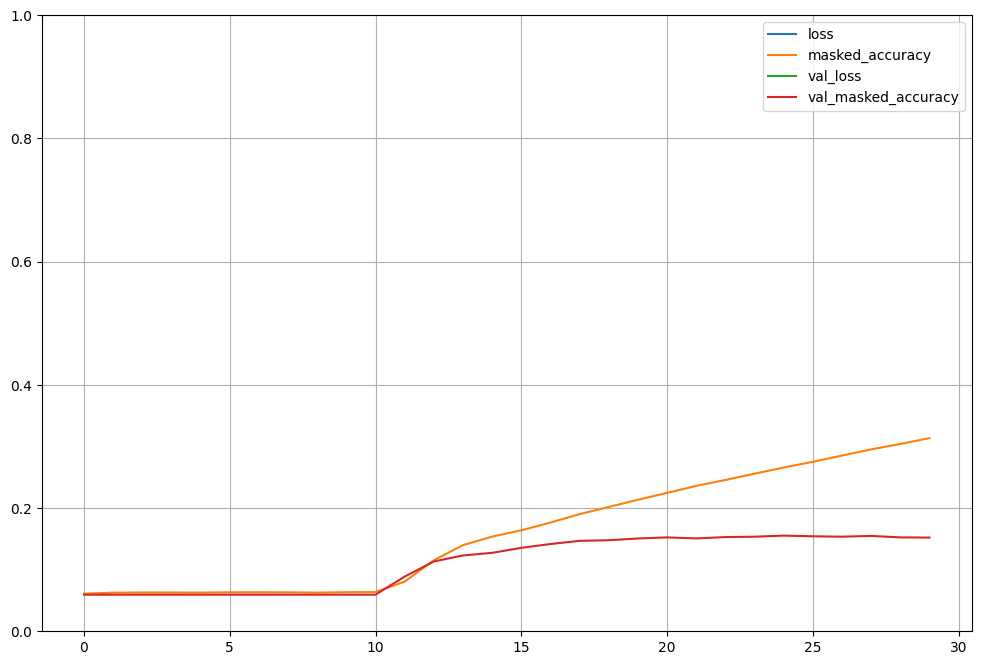

In [ ]:
pd.DataFrame(history2.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=c95d0e6d5058a9b41964d3a84f25c7143b1c31064b7ef0307c1348cede2f4604
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
def calculate_rouge(reference_texts, generated_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for ref, gen in zip(reference_texts, generated_texts):
        score = scorer.score(ref, gen)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_scores


In [ ]:
# Generate summaries using the model for a subset of the test data
reference_texts = data['summary'].tolist()[:100]  # Reference summaries
generated_texts = [predict(text) for text in data['text'][:100]]  # Summaries generated by the model

rouge_scores = calculate_rouge(reference_texts, generated_texts)
print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")


KeyboardInterrupt: 

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")


In [ ]:
# Save the trained model and tokenizer locally
transformer2.save_pretrained("./transformer_model")
tokenizer.save_pretrained("./transformer_model")

AttributeError: 'Transformer' object has no attribute 'save_pretrained'

In [ ]:
import os

# Create a directory to save the model
model_dir = "./transformer_model"
os.makedirs(model_dir, exist_ok=True)

# Save your custom Transformer model using TensorFlow's save method
transformer2.save(model_dir)


In [ ]:
from huggingface_hub import HfApi, HfFolder

# Initialize API and create a repository on Hugging Face Hub
api = HfApi()
repo_url = api.create_repo("transformer-text-summarization-model", token=HfFolder.get_token())

# Upload the model to the repository
api.upload_folder(
    folder_path=model_dir,
    repo_id="PrathameshC/transformer-text-summarization-model",  # Replace with your username and repo name
    commit_message="Initial commit"
)

print(f"Model pushed to: {repo_url}")


saved_model.pb:   0%|          | 0.00/7.42M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/179k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/191M [00:00<?, ?B/s]

Model pushed to: https://huggingface.co/PrathameshC/transformer-text-summarization-model
